In [1]:
import sys; sys.path.append("..")
from models.utils import *

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS

import matplotlib.pyplot as plt

In [16]:
from importlib import reload 
import models.plotting_utils
reload(models.plotting_utils)

<module 'models.plotting_utils' from '/Users/emiliolr/Desktop/GTC-OTP/notebooks/../models/plotting_utils.py'>

In [3]:
# data_home = "/mnt/g/My Drive/GTC/solodoch_data_minimal"
data_home = "/Users/emiliolr/Google Drive/My Drive/GTC/"
lats = ["26N", "30S", "55S", "60S"]

In [4]:
lat = lats[3]
inputs = xr.open_dataset(f"{data_home}/solodoch_data_minimal/{lat}.nc")
inputs

<xarray.Dataset>
Dimensions:    (time: 288, latitude: 1, longitude: 720)
Coordinates:
  * latitude   (latitude) float32 -59.75
  * longitude  (longitude) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * time       (time) datetime64[ns] 1992-01-16T18:00:00 ... 2015-12-16T12:00:00
Data variables:
    SSH        (time, latitude, longitude) float32 ...
    ZWS        (time, latitude, longitude) float32 ...
    OBP        (time, latitude, longitude) float32 ...
    SSS        (time, latitude, longitude) float32 ...
    SST        (time, latitude, longitude) float32 ...

In [5]:
outputs = xr.open_dataset(f"{data_home}/streamfunctions_ecco/{lat}/PSI_{lat} (1).nc")
outputs = outputs.sel(time = slice('1992-01-16', '2015-12-16'))
outputs = outputs.moc.to_dataset()
outputs = outputs.rename({'lat' : 'latitude'})
outputs

<xarray.Dataset>
Dimensions:   (latitude: 1, time: 288)
Coordinates:
  * latitude  (latitude) int32 -60
  * time      (time) datetime64[ns] 1992-01-16T18:00:00 ... 2015-12-16T12:00:00
Data variables:
    moc       (time, latitude) float64 ...

In [6]:
# apply whatever preprocessing we want *before* calling reshape_inputs
pp_data = apply_preprocessing(inputs,
                              mode="inputs",
                              remove_season=True,
                              remove_trend=True,
                              standardize=True,
                              lowpass=False)

# reshape as desired and convert to a numpy array
pp_data_np = reshape_inputs(pp_data, keep_coords=["time"])

# MOC strength from data
strength = apply_preprocessing(outputs,
                               mode="outputs",
                               remove_season=True,
                               remove_trend=True,
                               standardize=False,
                               lowpass=False)
strength_np = strength.moc.squeeze().values
X = pp_data_np; y = strength_np

# shuffle data
# p = np.random.permutation(len(y))
# X, y = X[p], y[p]

print()
print('Inputs shape:', X.shape)
print('Outputs shape:', y.shape)

axes: ['time', 'feature']
variables: ['SSH', 'SST', 'SSS', 'OBP', 'ZWS']
shape: (288, 5)

Inputs shape: (288, 5)
Outputs shape: (288,)


In [7]:
class SMWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, alpha=0.1, L1_wt=0.1):
        self.alpha = alpha
        self.L1_wt = L1_wt
        self.model = None

    def fit(self, X, y):
        self.model = sm.OLS(y, X).fit_regularized(alpha=self.alpha, L1_wt=self.L1_wt)
        return self

    def predict(self, X):
        return self.model.predict(X)
    
# add bias term
X = sm.add_constant(X)

# train/val/test split - no shuffling to ensure that the first 70% of timeseries is train and the last 30% is test!
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, stratify=None, random_state=123456)

# hyperparameters to optimise
param_grid = {
    "alpha": np.logspace(-4, 4, 10),
    "L1_wt": np.linspace(0, 1, 10)
}

# grid search - 10-fold cross-validation
grid_search = GridSearchCV(SMWrapper(), param_grid, cv=10, scoring="neg_mean_squared_error")
grid_search.fit(X_train, y_train)

# report best result
print(f"Best MSE (cross-validation): {round(-grid_search.best_score_, 3)}")

# report test performance
y_pred = grid_search.best_estimator_.predict(X_test)
r2 = round(r2_score(y_test, y_pred), 3)
mse = round(mean_squared_error(y_test, y_pred), 3)

print(f"Test R^2: {r2}")
print(f"Test MSE: {mse}")

Best MSE (cross-validation): 0.213
Test R^2: 0.992
Test MSE: 0.247


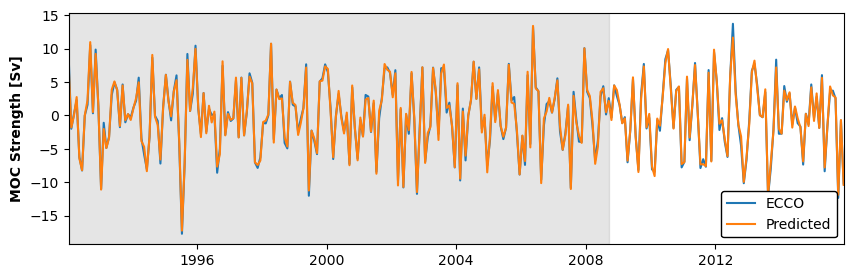

In [8]:
# Extracting all predictions in time order
train_set_pred = grid_search.best_estimator_.predict(X_train)
test_set_pred = grid_search.best_estimator_.predict(X_test)
all_preds = np.concatenate([train_set_pred, test_set_pred])

time = outputs.time.values

fig, ax = models.plotting_utils.timeseries_comparison(all_preds, y, time, len(X_train))
plt.show()

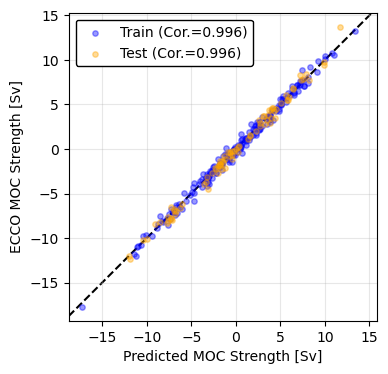

In [19]:
# Alternate view: looking at a scatterplot of predicted vs. actual
fig, ax = models.plotting_utils.pred_vs_actual(train_set_pred, test_set_pred, y_train, y_test)
plt.show()